In [1]:
cd speechsamples/voxceleb_exp

[Errno 2] No such file or directory: 'speechsamples/voxceleb_exp'
/local_raid/data/peterd/Projects/speechsamples/voxceleb_exp


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchaudio
import sys, os
sys.path.append('torchaudio-contrib')
import tac
from torch import nn, optim
from time import time
from torch.utils.data.sampler import Sampler
from torch.utils.data import DataLoader

basepath = '/local_raid/data/peterd'
manifest_filepath = basepath+'/data/Language/librispeech/converted_aligned_phones.txt'
librispeech_path = basepath+'/data/Language/librispeech/LibriSpeech/train-clean-100/'
lr0 = 1e-3

In [3]:
from torch.utils.data import Dataset

def get_librispeech_filepath(librispeech_path, filecode):
    fparts = filecode.split('-')
    return os.path.join(librispeech_path, fparts[0], fparts[1], filecode+'.flac')

class LibriSpeechDataset(Dataset):
    def __init__(self, manifest_filepath, librispeech_path, chunk=None, index=None, sample_rate=16000, normalize=True):
        """
        """
        with open(manifest_filepath) as f:
            afiles = f.readlines()
        files = []
        for afile in afiles:
            asplit = afile.split(' ')
            filecode = asplit[0]
            speaker_id = int(filecode.split('-')[0])
            phones = torch.LongTensor([int(phone) for phone in asplit[1:]])
            audiolen = len(phones)*.01
            if len(phones)<=(chunk*100+1):
                continue
            else:
                files.append([filecode, speaker_id, phones, audiolen])
        if index is None:
            self.files = files
        else:
            self.files = [files[ii] for ii in index]
        self.size = len(self.files)
        self.librispeech_path = librispeech_path
        self.train = True
        self.sample_rate = sample_rate
        self.normalize = normalize
        self.chunk = chunk
        super(LibriSpeechDataset, self).__init__()

    def parse_audio(self, audio_path, index=None):
        sound, _ = torchaudio.load(audio_path, normalization=self.normalize)
        if index is not None:
            sound = sound[:,index]
        return sound

    def __getitem__(self, index):
        sample = self.files[index]
        filecode, speaker_id, phones, audiolen = sample[0], sample[1], sample[2], sample[3]
        # index 3 second window
        if self.chunk is not None:
            offset = np.random.uniform(0, float(audiolen)-self.chunk)
            offset = int(np.floor(offset*100))
            index_phones = np.arange(offset, offset+int(self.chunk*100)+1)
            offset = offset*(self.sample_rate/100)
            index = np.arange(offset, offset+self.sample_rate*self.chunk)
        else:
            index = None   
        y = self.parse_audio(get_librispeech_filepath(self.librispeech_path, filecode), index=index)
        target = (speaker_id, phones[index_phones])
        return y, target

    def __len__(self):
        return self.size
    
class ModFilter(nn.Module):

    def __init__(self, temporal, spectral):
        super(ModFilter, self).__init__()
        self.temporal = temporal
        self.spectral = spectral
        
    def forward(self, x):
        print(x.shape)
        spec_fft = torch.rfft(x, 2)
        print(spec_fft.shape)
        spec_fft_abs = np.sqrt(spec_fft[:,:,:,:,0]**2+spec_fft[:,:,:,:,1]**2)
        gainmap = torch.zeros(spec_fft.shape[:4])
        if self.temporal is not None:
            gainmap[0,0,:,:self.temporal] = 1
            gainmap[0,0,:,self.temporal] = .5
        if self.spectral is not None:
            gainmap[0,0,:self.spectral,:] = 1
            gainmap[0,0,self.spectral,:] = .5
            gainmap[0,0,-self.spectral:,:] = 1
            gainmap[0,0,-self.spectral,:] = .5
        spec_fft_new = spec_fft*gainmap[:,:,:,:,None].repeat(1,1,1,1,2)
        spec_new = torch.irfft(spec_fft_new, 2)
        return spec_new
    
class BucketingSampler(Sampler):
    def __init__(self, data_source, batch_size=1):
        """
        """
        super(BucketingSampler, self).__init__(data_source)
        self.data_source = data_source
        ids = list(range(0, len(data_source)))
        np.random.shuffle(ids)
        self.bins = [ids[i:i + batch_size] for i in range(0, len(ids)-len(ids)%batch_size, batch_size)]


    def __iter__(self):
        for ids in self.bins:
            np.random.shuffle(ids)
            yield ids

    def __len__(self):
        return len(self.bins)

    def shuffle(self, epoch):
        np.random.shuffle(self.bins)

In [4]:
# max([max(bb) for bb in test_sampler.bins])
# len(train_dataset)

In [5]:
class SpecNet(nn.Module):

    def __init__(self, embed_size=256):
        super(SpecNet, self).__init__()
#         self.mel = tac.layers.Melspectrogram(128, 16000, n_fft=2**9)
#         self.lnorm = torch.nn.LayerNorm((1,128,376))
#         self.n_future = 12
        self.convnet = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(128,1), stride=1,
                                   bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=(1,3), stride=1,
                                   bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, embed_size, kernel_size=(1,3), stride=1,
                                   bias=False),
            nn.BatchNorm2d(embed_size),
            nn.LeakyReLU()
            )
        self.gru = nn.GRU(input_size=embed_size, hidden_size=embed_size)
        self.lin = nn.Linear(embed_size, 41)

    def forward(self, data):
#         spec = self.lnorm(self.mel(data))
        conv_out = self.convnet(spec)
        gru_in = conv_out[:,:,0,:].transpose(1,2).transpose(0,1)
        gru_out = self.gru(gru_in)[0]
        prediction = self.lin(gru_out).transpose(0,1).transpose(1,2)
        return prediction

In [11]:
train_dataset = LibriSpeechDataset(manifest_filepath, librispeech_path, 3, index=None)
n_files = len(train_dataset)

In [12]:
file_index = np.arange(n_files)
np.random.shuffle(file_index)
test_index = file_index[-640:]
train_index = file_index[:-640]

In [13]:
batch_size = 64
train_dataset = LibriSpeechDataset(manifest_filepath, librispeech_path, 3, index=train_index)
train_sampler = BucketingSampler(train_dataset, batch_size=batch_size)
train_loader = DataLoader(train_dataset, num_workers=1, batch_sampler=train_sampler)
test_dataset = LibriSpeechDataset(manifest_filepath, librispeech_path, 3, index=test_index)
test_sampler = BucketingSampler(test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, num_workers=1, batch_sampler=test_sampler)

In [14]:
# test_dataset[0]

In [15]:
model = SpecNet()

In [16]:
mel = tac.layers.Melspectrogram(128, train_dataset.sample_rate, hop=int(.01*train_dataset.sample_rate), n_fft=2**10)
modfilter = ModFilter(None, 5)
ce_loss = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr0)
n_batch = int(len(train_dataset)/batch_size)

In [19]:
train_loss = []
test_loss = []
accuracies = []
for epoch in range(100):
    train_loss.append([])
    model.train()
    avg_loss = 0.
    epoch_start = time()
    train_sampler.shuffle(epoch)
    for i, (data) in enumerate(train_loader, start=0):

        print('Batch {} of {}'.format(i, n_batch))

        y, (speaker_id, phones) = data

        spec = mel(y)
        spec = tac.scaling.amplitude_to_db(spec)

        if False:
            spec = modfilter(spec)

        out = model(spec)
        loss = ce_loss(out, phones[:,2:-2])
        avg_loss += loss.item()

        # compute gradient
        optimizer.zero_grad()
        loss.backward()

        # if False:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)

        # torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_norm)
        if True:
            optimizer.step()    

        if (i>0) and (i%10==0):
            print('Average loss: {}'.format(avg_loss/i))
            print('Elapsed time: {} seconds'.format(time()-epoch_start))
            train_loss[-1].append(avg_loss/i)
            
    model.eval()
    avg_loss = 0.
    accuracy = 0.
    epoch_start = time()
    print('Testing..')
    for i, (data) in enumerate(test_loader, start=0):
        
        print(i)
        y, (speaker_id, phones) = data

        spec = mel(y)
        spec = tac.scaling.amplitude_to_db(spec)

        if False:
            spec = modfilter(spec)

        out = model(spec)
        loss = ce_loss(out, phones[:,2:-2])
        accuracy += torch.sum(out.argmax(1) == phones[:,2:-2]).item() / (batch_size*(phones.shape[1]-4))
        avg_loss += loss.item()
        
    test_loss.append(avg_loss/i)
    accuracies.append(accuracy/i)
    print('Test loss: {}'.format(avg_loss/i))
    print('Test accuracy: {}'.format(accuracy/i))
    
    if (epoch==0) or (avg_loss/i < best_val_loss):
        best_val_loss = avg_loss/i
        with open('./spec_net_1.pkl', 'wb') as f:
            torch.save(model.state_dict(), f)    

Batch 0 of 426
Batch 1 of 426
Batch 2 of 426
Batch 3 of 426
Batch 4 of 426
Batch 5 of 426
Batch 6 of 426
Batch 7 of 426
Batch 8 of 426
Batch 9 of 426
Batch 10 of 426
Average loss: 1.3031778693199159
Elapsed time: 17.42814040184021 seconds
Batch 11 of 426
Batch 12 of 426
Batch 13 of 426
Batch 14 of 426
Batch 15 of 426
Batch 16 of 426
Batch 17 of 426
Batch 18 of 426
Batch 19 of 426
Batch 20 of 426
Average loss: 1.248548263311386
Elapsed time: 32.399444341659546 seconds
Batch 21 of 426
Batch 22 of 426
Batch 23 of 426
Batch 24 of 426
Batch 25 of 426
Batch 26 of 426
Batch 27 of 426
Batch 28 of 426
Batch 29 of 426
Batch 30 of 426
Average loss: 1.235486352443695
Elapsed time: 46.37980675697327 seconds
Batch 31 of 426
Batch 32 of 426
Batch 33 of 426
Batch 34 of 426
Batch 35 of 426
Batch 36 of 426
Batch 37 of 426
Batch 38 of 426
Batch 39 of 426
Batch 40 of 426
Average loss: 1.2189567059278488
Elapsed time: 60.8571834564209 seconds
Batch 41 of 426
Batch 42 of 426
Batch 43 of 426
Batch 44 of 426


Batch 343 of 426
Batch 344 of 426
Batch 345 of 426
Batch 346 of 426
Batch 347 of 426
Batch 348 of 426
Batch 349 of 426
Batch 350 of 426
Average loss: 1.1297564234052386
Elapsed time: 511.1360170841217 seconds
Batch 351 of 426
Batch 352 of 426
Batch 353 of 426
Batch 354 of 426
Batch 355 of 426
Batch 356 of 426
Batch 357 of 426
Batch 358 of 426
Batch 359 of 426
Batch 360 of 426
Average loss: 1.1279272048009767
Elapsed time: 525.4164249897003 seconds
Batch 361 of 426
Batch 362 of 426
Batch 363 of 426
Batch 364 of 426
Batch 365 of 426
Batch 366 of 426
Batch 367 of 426
Batch 368 of 426
Batch 369 of 426
Batch 370 of 426
Average loss: 1.1259294840129646
Elapsed time: 539.6787548065186 seconds
Batch 371 of 426
Batch 372 of 426
Batch 373 of 426
Batch 374 of 426
Batch 375 of 426
Batch 376 of 426
Batch 377 of 426
Batch 378 of 426
Batch 379 of 426
Batch 380 of 426
Average loss: 1.123762019057023
Elapsed time: 553.4506583213806 seconds
Batch 381 of 426
Batch 382 of 426
Batch 383 of 426
Batch 384 of

Batch 258 of 426
Batch 259 of 426
Batch 260 of 426
Average loss: 1.0190917750963797
Elapsed time: 383.93793749809265 seconds
Batch 261 of 426
Batch 262 of 426
Batch 263 of 426
Batch 264 of 426
Batch 265 of 426
Batch 266 of 426
Batch 267 of 426
Batch 268 of 426
Batch 269 of 426
Batch 270 of 426
Average loss: 1.0175419145160252
Elapsed time: 398.2686996459961 seconds
Batch 271 of 426
Batch 272 of 426
Batch 273 of 426
Batch 274 of 426
Batch 275 of 426
Batch 276 of 426
Batch 277 of 426
Batch 278 of 426
Batch 279 of 426
Batch 280 of 426
Average loss: 1.0166154165353094
Elapsed time: 412.1412031650543 seconds
Batch 281 of 426
Batch 282 of 426
Batch 283 of 426
Batch 284 of 426
Batch 285 of 426
Batch 286 of 426
Batch 287 of 426
Batch 288 of 426
Batch 289 of 426
Batch 290 of 426
Average loss: 1.0155788623053452
Elapsed time: 426.41751170158386 seconds
Batch 291 of 426
Batch 292 of 426
Batch 293 of 426
Batch 294 of 426
Batch 295 of 426
Batch 296 of 426
Batch 297 of 426
Batch 298 of 426
Batch 299

Batch 172 of 426
Batch 173 of 426
Batch 174 of 426
Batch 175 of 426
Batch 176 of 426
Batch 177 of 426
Batch 178 of 426
Batch 179 of 426
Batch 180 of 426
Average loss: 0.962190889981058
Elapsed time: 266.76190161705017 seconds
Batch 181 of 426
Batch 182 of 426
Batch 183 of 426
Batch 184 of 426
Batch 185 of 426
Batch 186 of 426
Batch 187 of 426
Batch 188 of 426
Batch 189 of 426
Batch 190 of 426
Average loss: 0.961713855517538
Elapsed time: 280.84246706962585 seconds
Batch 191 of 426
Batch 192 of 426
Batch 193 of 426
Batch 194 of 426
Batch 195 of 426
Batch 196 of 426
Batch 197 of 426
Batch 198 of 426
Batch 199 of 426
Batch 200 of 426
Average loss: 0.9614164841175079
Elapsed time: 295.3889536857605 seconds
Batch 201 of 426
Batch 202 of 426
Batch 203 of 426
Batch 204 of 426
Batch 205 of 426
Batch 206 of 426
Batch 207 of 426
Batch 208 of 426
Batch 209 of 426
Batch 210 of 426
Average loss: 0.9613138369151524
Elapsed time: 309.73291301727295 seconds
Batch 211 of 426
Batch 212 of 426
Batch 213 

Batch 86 of 426
Batch 87 of 426
Batch 88 of 426
Batch 89 of 426
Batch 90 of 426
Average loss: 0.930628256003062
Elapsed time: 133.03834176063538 seconds
Batch 91 of 426
Batch 92 of 426
Batch 93 of 426
Batch 94 of 426
Batch 95 of 426
Batch 96 of 426
Batch 97 of 426
Batch 98 of 426
Batch 99 of 426
Batch 100 of 426
Average loss: 0.9293472743034363
Elapsed time: 147.7346773147583 seconds
Batch 101 of 426
Batch 102 of 426
Batch 103 of 426
Batch 104 of 426
Batch 105 of 426
Batch 106 of 426
Batch 107 of 426
Batch 108 of 426
Batch 109 of 426
Batch 110 of 426
Average loss: 0.9253719291903756
Elapsed time: 162.38472151756287 seconds
Batch 111 of 426
Batch 112 of 426
Batch 113 of 426
Batch 114 of 426
Batch 115 of 426
Batch 116 of 426
Batch 117 of 426
Batch 118 of 426
Batch 119 of 426
Batch 120 of 426
Average loss: 0.9234180182218552
Elapsed time: 178.31606531143188 seconds
Batch 121 of 426
Batch 122 of 426
Batch 123 of 426
Batch 124 of 426
Batch 125 of 426
Batch 126 of 426
Batch 127 of 426
Batch 

Testing..
0
1
2
3
4
5
6
7
8
9
Test loss: 0.9915215108129714
Test accuracy: 0.8015221661054995
Batch 0 of 426
Batch 1 of 426
Batch 2 of 426
Batch 3 of 426
Batch 4 of 426
Batch 5 of 426
Batch 6 of 426
Batch 7 of 426
Batch 8 of 426
Batch 9 of 426
Batch 10 of 426
Average loss: 0.9496336996555328
Elapsed time: 17.31628394126892 seconds
Batch 11 of 426
Batch 12 of 426
Batch 13 of 426
Batch 14 of 426
Batch 15 of 426
Batch 16 of 426
Batch 17 of 426
Batch 18 of 426
Batch 19 of 426
Batch 20 of 426
Average loss: 0.9135620713233947
Elapsed time: 32.0336594581604 seconds
Batch 21 of 426
Batch 22 of 426
Batch 23 of 426
Batch 24 of 426
Batch 25 of 426
Batch 26 of 426
Batch 27 of 426
Batch 28 of 426
Batch 29 of 426
Batch 30 of 426
Average loss: 0.8963628490765889
Elapsed time: 47.26486420631409 seconds
Batch 31 of 426
Batch 32 of 426
Batch 33 of 426
Batch 34 of 426
Batch 35 of 426
Batch 36 of 426
Batch 37 of 426
Batch 38 of 426
Batch 39 of 426
Batch 40 of 426
Average loss: 0.8929470136761666
Elapsed t

Average loss: 0.8801110960104886
Elapsed time: 501.4225196838379 seconds
Batch 341 of 426
Batch 342 of 426
Batch 343 of 426
Batch 344 of 426
Batch 345 of 426
Batch 346 of 426
Batch 347 of 426
Batch 348 of 426
Batch 349 of 426
Batch 350 of 426
Average loss: 0.8800526896544866
Elapsed time: 516.5928525924683 seconds
Batch 351 of 426
Batch 352 of 426
Batch 353 of 426
Batch 354 of 426
Batch 355 of 426
Batch 356 of 426
Batch 357 of 426
Batch 358 of 426
Batch 359 of 426
Batch 360 of 426
Average loss: 0.8793258301085896
Elapsed time: 531.7223494052887 seconds
Batch 361 of 426
Batch 362 of 426
Batch 363 of 426
Batch 364 of 426
Batch 365 of 426
Batch 366 of 426
Batch 367 of 426
Batch 368 of 426
Batch 369 of 426
Batch 370 of 426
Average loss: 0.879241470388464
Elapsed time: 546.5857422351837 seconds
Batch 371 of 426
Batch 372 of 426
Batch 373 of 426
Batch 374 of 426
Batch 375 of 426
Batch 376 of 426
Batch 377 of 426
Batch 378 of 426
Batch 379 of 426
Batch 380 of 426
Average loss: 0.8790947343173

Batch 252 of 426
Batch 253 of 426
Batch 254 of 426
Batch 255 of 426
Batch 256 of 426
Batch 257 of 426
Batch 258 of 426
Batch 259 of 426
Batch 260 of 426
Average loss: 0.8618233783886983
Elapsed time: 380.8306097984314 seconds
Batch 261 of 426
Batch 262 of 426
Batch 263 of 426
Batch 264 of 426
Batch 265 of 426
Batch 266 of 426
Batch 267 of 426
Batch 268 of 426
Batch 269 of 426
Batch 270 of 426
Average loss: 0.861036295802505
Elapsed time: 395.24860310554504 seconds
Batch 271 of 426
Batch 272 of 426
Batch 273 of 426
Batch 274 of 426
Batch 275 of 426
Batch 276 of 426
Batch 277 of 426
Batch 278 of 426
Batch 279 of 426
Batch 280 of 426
Average loss: 0.8610429614782333
Elapsed time: 409.06120681762695 seconds
Batch 281 of 426
Batch 282 of 426
Batch 283 of 426
Batch 284 of 426
Batch 285 of 426
Batch 286 of 426
Batch 287 of 426
Batch 288 of 426
Batch 289 of 426
Batch 290 of 426
Average loss: 0.8609730512931429
Elapsed time: 423.41313457489014 seconds
Batch 291 of 426
Batch 292 of 426
Batch 293

Batch 168 of 426
Batch 169 of 426
Batch 170 of 426
Average loss: 0.8458255855476156
Elapsed time: 267.1677134037018 seconds
Batch 171 of 426
Batch 172 of 426
Batch 173 of 426
Batch 174 of 426
Batch 175 of 426
Batch 176 of 426
Batch 177 of 426
Batch 178 of 426
Batch 179 of 426
Batch 180 of 426
Average loss: 0.8455090751250585
Elapsed time: 285.15364384651184 seconds
Batch 181 of 426
Batch 182 of 426
Batch 183 of 426
Batch 184 of 426
Batch 185 of 426
Batch 186 of 426
Batch 187 of 426
Batch 188 of 426
Batch 189 of 426
Batch 190 of 426
Average loss: 0.8447416013792941
Elapsed time: 303.4036786556244 seconds
Batch 191 of 426
Batch 192 of 426
Batch 193 of 426
Batch 194 of 426
Batch 195 of 426
Batch 196 of 426
Batch 197 of 426
Batch 198 of 426
Batch 199 of 426
Batch 200 of 426
Average loss: 0.843939069211483
Elapsed time: 321.83709955215454 seconds
Batch 201 of 426
Batch 202 of 426
Batch 203 of 426
Batch 204 of 426
Batch 205 of 426
Batch 206 of 426
Batch 207 of 426
Batch 208 of 426
Batch 209 

Batch 82 of 426
Batch 83 of 426
Batch 84 of 426
Batch 85 of 426
Batch 86 of 426
Batch 87 of 426
Batch 88 of 426
Batch 89 of 426
Batch 90 of 426
Average loss: 0.8325173371367984
Elapsed time: 164.48676085472107 seconds
Batch 91 of 426
Batch 92 of 426
Batch 93 of 426
Batch 94 of 426
Batch 95 of 426
Batch 154 of 426
Batch 155 of 426
Batch 156 of 426
Batch 157 of 426
Batch 158 of 426
Batch 159 of 426
Batch 160 of 426
Average loss: 0.8241412881761789
Elapsed time: 290.9791958332062 seconds
Batch 161 of 426
Batch 162 of 426
Batch 163 of 426
Batch 164 of 426
Batch 165 of 426
Batch 166 of 426
Batch 167 of 426
Batch 168 of 426
Batch 169 of 426
Batch 170 of 426
Average loss: 0.8241149162544924
Elapsed time: 309.0236494541168 seconds
Batch 171 of 426
Batch 172 of 426
Batch 173 of 426
Batch 174 of 426
Batch 175 of 426
Batch 176 of 426
Batch 177 of 426
Batch 178 of 426
Batch 179 of 426
Batch 180 of 426
Average loss: 0.8252702679899003
Elapsed time: 328.42652773857117 seconds
Batch 181 of 426
Batch 

Batch 54 of 426
Batch 55 of 426
Batch 56 of 426
Batch 57 of 426
Batch 58 of 426
Batch 59 of 426
Batch 60 of 426
Average loss: 0.8256680419047674
Elapsed time: 111.08055138587952 seconds
Batch 61 of 426
Batch 62 of 426
Batch 63 of 426
Batch 64 of 426
Batch 65 of 426
Batch 66 of 426
Batch 67 of 426
Batch 68 of 426
Batch 69 of 426
Batch 70 of 426
Average loss: 0.8208490448338644
Elapsed time: 129.13674783706665 seconds
Batch 71 of 426
Batch 72 of 426
Batch 73 of 426
Batch 74 of 426
Batch 75 of 426
Batch 76 of 426
Batch 77 of 426
Batch 78 of 426
Batch 79 of 426
Batch 80 of 426
Average loss: 0.8213290810585022
Elapsed time: 147.10624742507935 seconds
Batch 81 of 426
Batch 82 of 426
Batch 83 of 426
Batch 84 of 426
Batch 85 of 426
Batch 86 of 426
Batch 87 of 426
Batch 88 of 426
Batch 89 of 426
Batch 90 of 426
Average loss: 0.8206114908059438
Elapsed time: 163.9483208656311 seconds
Batch 91 of 426
Batch 92 of 426
Batch 93 of 426
Batch 94 of 426
Batch 95 of 426
Batch 96 of 426
Batch 97 of 426
B

Batch 393 of 426
Batch 394 of 426
Batch 395 of 426
Batch 396 of 426
Batch 397 of 426
Batch 398 of 426
Batch 399 of 426
Batch 400 of 426
Average loss: 0.8093265292048454
Elapsed time: 631.9709656238556 seconds
Batch 401 of 426
Batch 402 of 426
Batch 403 of 426
Batch 404 of 426
Batch 405 of 426
Batch 406 of 426
Batch 407 of 426
Batch 408 of 426
Batch 409 of 426
Batch 410 of 426
Average loss: 0.8088544541742744
Elapsed time: 647.9591743946075 seconds
Batch 411 of 426
Batch 412 of 426
Batch 413 of 426
Batch 414 of 426
Batch 415 of 426
Batch 416 of 426
Batch 417 of 426
Batch 418 of 426
Batch 419 of 426
Batch 420 of 426
Average loss: 0.8082652700798852
Elapsed time: 663.1577684879303 seconds
Batch 421 of 426
Batch 422 of 426
Batch 423 of 426
Batch 424 of 426
Batch 425 of 426
Testing..
0
1
2
3
4
5
6
7
8
9
Test loss: 0.9142963356441922
Test accuracy: 0.8211805555555557
Batch 0 of 426
Batch 1 of 426
Batch 2 of 426
Batch 3 of 426
Batch 4 of 426
Batch 5 of 426
Batch 6 of 426
Batch 7 of 426
Batch 

Batch 308 of 426
Batch 309 of 426
Batch 310 of 426
Average loss: 0.8016512755424746
Elapsed time: 462.007266998291 seconds
Batch 311 of 426
Batch 312 of 426
Batch 313 of 426
Batch 314 of 426
Batch 315 of 426
Batch 316 of 426
Batch 317 of 426
Batch 318 of 426
Batch 319 of 426
Batch 320 of 426
Average loss: 0.8020338514819741
Elapsed time: 476.74232292175293 seconds
Batch 321 of 426
Batch 322 of 426
Batch 323 of 426
Batch 324 of 426
Batch 325 of 426
Batch 326 of 426
Batch 327 of 426
Batch 328 of 426
Batch 329 of 426
Batch 330 of 426
Average loss: 0.8019491730314312
Elapsed time: 491.4788873195648 seconds
Batch 331 of 426
Batch 332 of 426
Batch 333 of 426
Batch 334 of 426
Batch 335 of 426
Batch 336 of 426
Batch 337 of 426
Batch 338 of 426
Batch 339 of 426
Batch 340 of 426
Average loss: 0.8018862338627086
Elapsed time: 505.71314001083374 seconds
Batch 341 of 426
Batch 342 of 426
Batch 343 of 426
Batch 344 of 426
Batch 345 of 426
Batch 346 of 426
Batch 347 of 426
Batch 348 of 426
Batch 349 

Batch 222 of 426
Batch 223 of 426
Batch 224 of 426
Batch 225 of 426
Batch 226 of 426
Batch 227 of 426
Batch 228 of 426
Batch 229 of 426
Batch 230 of 426
Average loss: 0.7917007933492246
Elapsed time: 334.47557854652405 seconds
Batch 231 of 426
Batch 232 of 426
Batch 233 of 426
Batch 234 of 426
Batch 235 of 426
Batch 236 of 426
Batch 237 of 426
Batch 238 of 426
Batch 239 of 426
Batch 240 of 426
Average loss: 0.7921277319391569
Elapsed time: 348.66752409935 seconds
Batch 241 of 426
Batch 242 of 426
Batch 243 of 426
Batch 244 of 426
Batch 245 of 426
Batch 246 of 426
Batch 247 of 426
Batch 248 of 426
Batch 249 of 426
Batch 250 of 426
Average loss: 0.7921593477725982
Elapsed time: 362.6731014251709 seconds
Batch 251 of 426
Batch 252 of 426
Batch 253 of 426
Batch 254 of 426
Batch 255 of 426
Batch 256 of 426
Batch 257 of 426
Batch 258 of 426
Batch 259 of 426
Batch 260 of 426
Average loss: 0.7919591658390486
Elapsed time: 376.62412214279175 seconds
Batch 261 of 426
Batch 262 of 426
Batch 263 o

Batch 137 of 426
Batch 138 of 426
Batch 139 of 426
Batch 140 of 426
Average loss: 0.7781160997492926
Elapsed time: 207.69779205322266 seconds
Batch 141 of 426
Batch 142 of 426
Batch 143 of 426
Batch 144 of 426
Batch 145 of 426
Batch 146 of 426
Batch 147 of 426
Batch 148 of 426
Batch 149 of 426
Batch 150 of 426
Average loss: 0.7782354621092479
Elapsed time: 221.98611116409302 seconds
Batch 151 of 426
Batch 152 of 426
Batch 153 of 426
Batch 154 of 426
Batch 155 of 426
Batch 156 of 426
Batch 157 of 426
Batch 158 of 426
Batch 159 of 426
Batch 160 of 426
Average loss: 0.7782356757670641
Elapsed time: 236.25544834136963 seconds
Batch 161 of 426
Batch 162 of 426
Batch 163 of 426
Batch 164 of 426
Batch 165 of 426
Batch 166 of 426
Batch 167 of 426
Batch 168 of 426
Batch 169 of 426
Batch 170 of 426
Average loss: 0.7781178684795604
Elapsed time: 251.72018671035767 seconds
Batch 171 of 426
Batch 172 of 426
Batch 173 of 426
Batch 174 of 426
Batch 175 of 426
Batch 176 of 426
Batch 177 of 426
Batch 1

Batch 49 of 426
Batch 50 of 426
Average loss: 0.7898189926147461
Elapsed time: 74.62680244445801 seconds
Batch 51 of 426
Batch 52 of 426
Batch 53 of 426
Batch 54 of 426
Batch 55 of 426
Batch 56 of 426
Batch 57 of 426
Batch 58 of 426
Batch 59 of 426
Batch 60 of 426
Average loss: 0.7844411661227544
Elapsed time: 89.04168677330017 seconds
Batch 61 of 426
Batch 62 of 426
Batch 63 of 426
Batch 64 of 426
Batch 65 of 426
Batch 66 of 426
Batch 67 of 426
Batch 68 of 426
Batch 69 of 426
Batch 70 of 426
Average loss: 0.7820274063519069
Elapsed time: 103.59254574775696 seconds
Batch 71 of 426
Batch 72 of 426
Batch 73 of 426
Batch 74 of 426
Batch 75 of 426
Batch 76 of 426
Batch 77 of 426
Batch 78 of 426
Batch 79 of 426
Batch 80 of 426
Average loss: 0.7799507357180119
Elapsed time: 119.21663427352905 seconds
Batch 81 of 426
Batch 82 of 426
Batch 83 of 426
Batch 84 of 426
Batch 85 of 426
Batch 86 of 426
Batch 87 of 426
Batch 88 of 426
Batch 89 of 426
Batch 90 of 426
Average loss: 0.7772337973117829
E

Batch 388 of 426
Batch 389 of 426
Batch 390 of 426
Average loss: 0.7686744725092863
Elapsed time: 572.341383934021 seconds
Batch 391 of 426
Batch 392 of 426
Batch 393 of 426
Batch 394 of 426
Batch 395 of 426
Batch 396 of 426
Batch 397 of 426
Batch 398 of 426
Batch 399 of 426
Batch 400 of 426
Average loss: 0.7685630896687508
Elapsed time: 587.8612260818481 seconds
Batch 401 of 426
Batch 402 of 426
Batch 403 of 426
Batch 404 of 426
Batch 405 of 426
Batch 406 of 426
Batch 407 of 426
Batch 408 of 426
Batch 409 of 426
Batch 410 of 426
Average loss: 0.7682361586791713
Elapsed time: 602.7654044628143 seconds
Batch 411 of 426
Batch 412 of 426
Batch 413 of 426
Batch 414 of 426
Batch 415 of 426
Batch 416 of 426
Batch 417 of 426
Batch 418 of 426
Batch 419 of 426
Batch 420 of 426
Average loss: 0.7681143313646317
Elapsed time: 617.4762263298035 seconds
Batch 421 of 426
Batch 422 of 426
Batch 423 of 426
Batch 424 of 426
Batch 425 of 426
Testing..
0
1
2
3
4
5
6
7
8
9
Test loss: 0.8733843233850267
Tes

Batch 302 of 426
Batch 303 of 426
Batch 304 of 426
Batch 305 of 426
Batch 306 of 426
Batch 307 of 426
Batch 308 of 426
Batch 309 of 426
Batch 310 of 426
Average loss: 0.7602154541400171
Elapsed time: 449.5896065235138 seconds
Batch 311 of 426
Batch 312 of 426
Batch 313 of 426
Batch 314 of 426
Batch 315 of 426
Batch 316 of 426
Batch 317 of 426
Batch 318 of 426
Batch 319 of 426
Batch 320 of 426
Average loss: 0.7593412602320313
Elapsed time: 464.1348443031311 seconds
Batch 321 of 426
Batch 322 of 426
Batch 323 of 426
Batch 324 of 426
Batch 325 of 426
Batch 326 of 426
Batch 327 of 426
Batch 328 of 426
Batch 329 of 426
Batch 330 of 426
Average loss: 0.7594830657496597
Elapsed time: 478.45482301712036 seconds
Batch 331 of 426
Batch 332 of 426
Batch 333 of 426
Batch 334 of 426
Batch 335 of 426
Batch 336 of 426
Batch 337 of 426
Batch 338 of 426
Batch 339 of 426
Batch 340 of 426
Average loss: 0.759756192039041
Elapsed time: 493.1002187728882 seconds
Batch 341 of 426
Batch 342 of 426
Batch 343 o

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch 325 of 426
Batch 326 of 426
Batch 327 of 426
Batch 328 of 426
Batch 329 of 426
Batch 330 of 426
Average loss: 0.7141631552667329
Elapsed time: 629.5529243946075 seconds
Batch 331 of 426
Batch 332 of 426
Batch 333 of 426
Batch 334 of 426
Batch 335 of 426
Batch 336 of 426
Batch 337 of 426
Batch 338 of 426
Batch 339 of 426
Batch 340 of 426
Average loss: 0.7140596559819054
Elapsed time: 647.9912965297699 seconds
Batch 341 of 426
Batch 342 of 426
Batch 343 of 426
Batch 344 of 426
Batch 345 of 426
Batch 346 of 426
Batch 347 of 426
Batch 348 of 426
Batch 349 of 426
Batch 350 of 426
Average loss: 0.7140642562934331
Elapsed time: 667.037594795227 seconds
Batch 351 of 426
Batch 352 of 426
Batch 353 of 426
Batch 354 of 426
Batch 355 of 426
Batch 356 of 426
Batch 357 of 426
Batch 358 of 426
Batch 359 of 426
Batch 360 of 426
Average loss: 0.7138293269607756
Elapsed time: 685.8853652477264 seconds
Batch 361 of 426
Batch 362 of 426
Batch 363 of 426
Batch 364 of 426
Batch 365 of 426
Batch 366 of

Batch 240 of 426
Average loss: 0.713950922091802
Elapsed time: 413.71946454048157 seconds
Batch 241 of 426
Batch 242 of 426
Batch 243 of 426
Batch 244 of 426
Batch 245 of 426
Batch 246 of 426
Batch 247 of 426
Batch 248 of 426
Batch 249 of 426
Batch 250 of 426
Average loss: 0.7138349528312683
Elapsed time: 431.90138268470764 seconds
Batch 251 of 426
Batch 252 of 426
Batch 253 of 426
Batch 254 of 426
Batch 255 of 426
Batch 256 of 426
Batch 257 of 426
Batch 258 of 426
Batch 259 of 426
Batch 260 of 426
Average loss: 0.7139864495167365
Elapsed time: 450.5414638519287 seconds
Batch 261 of 426
Batch 262 of 426
Batch 263 of 426
Batch 264 of 426
Batch 265 of 426
Batch 266 of 426
Batch 267 of 426
Batch 268 of 426
Batch 269 of 426
Batch 270 of 426
Average loss: 0.7144394282941465
Elapsed time: 468.9626052379608 seconds
Batch 271 of 426
Batch 272 of 426
Batch 273 of 426
Batch 274 of 426
Batch 275 of 426
Batch 276 of 426
Batch 277 of 426
Batch 278 of 426
Batch 279 of 426
Batch 280 of 426
Average lo

Batch 152 of 426
Batch 153 of 426
Batch 154 of 426
Batch 155 of 426
Batch 156 of 426
Batch 157 of 426
Batch 158 of 426
Batch 159 of 426
Batch 160 of 426
Average loss: 0.7105993770062924
Elapsed time: 247.7610113620758 seconds
Batch 161 of 426
Batch 162 of 426
Batch 163 of 426
Batch 164 of 426
Batch 165 of 426
Batch 166 of 426
Batch 167 of 426
Batch 168 of 426
Batch 169 of 426
Batch 170 of 426
Average loss: 0.7104691393235151
Elapsed time: 263.7481596469879 seconds
Batch 171 of 426
Batch 172 of 426
Batch 173 of 426
Batch 174 of 426
Batch 175 of 426
Batch 176 of 426
Batch 177 of 426
Batch 178 of 426
Batch 179 of 426
Batch 180 of 426
Average loss: 0.7101226452324125
Elapsed time: 279.1572835445404 seconds
Batch 181 of 426
Batch 182 of 426
Batch 183 of 426
Batch 184 of 426
Batch 185 of 426
Batch 186 of 426
Batch 187 of 426
Batch 188 of 426
Batch 189 of 426
Batch 190 of 426
Average loss: 0.7104602261593468
Elapsed time: 295.4591245651245 seconds
Batch 191 of 426
Batch 192 of 426
Batch 193 o

KeyboardInterrupt: 

2

/local_raid/data/peterd/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/local_raid/data/peterd/miniconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


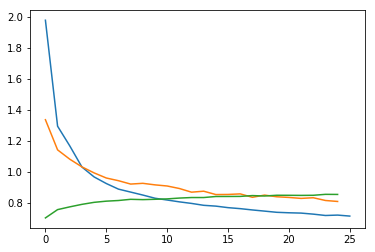

In [22]:
plt.plot([np.mean(t_l) for t_l in train_loss])
plt.plot(test_loss)
plt.plot(accuracies)

In [30]:
np.diff(test_loss)<0
# test_loss

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True, False, False,  True, False,
        True,  True,  True, False,  True,  True])

In [245]:
while True:
    model = SpecNet()

    model.eval()
    avg_loss = 0.
    accuracy = 0.
    epoch_start = time()
    print('Testing..')
    for i, (data) in enumerate(test_loader, start=0):

#         print(i)
        y, (speaker_id, phones) = data

        spec = mel(y)
        spec = tac.scaling.amplitude_to_db(spec)

        if False:
            spec = modfilter(spec)

        if False:
            phones_np = phones.numpy()
            np.random.shuffle(phones_np)
            phones = torch.LongTensor(phones_np)

        out = model(spec)
        loss = ce_loss(out, phones[:,2:-2])
        accuracy += torch.sum(out.argmax(1) == phones[:,2:-2]).item() / (batch_size*(phones.shape[1]-4))
        avg_loss += loss.item()

    print(accuracy/i)

Testing..
0.02110222596333707
Testing..
0.04819608118219229
Testing..
0.03620113168724279
Testing..
0.004407500935278714
Testing..
0.024182800224466894
Testing..
0.028876730265619148
Testing..
0.01554900860456416
Testing..
0.015408716797605686
Testing..
0.021733539094650207
Testing..
0.020950243172465393
Testing..


Traceback (most recent call last):
  File "/local_raid/data/peterd/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/local_raid/data/peterd/miniconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/local_raid/data/peterd/miniconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/local_raid/data/peterd/miniconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [23]:
print(np.unique([f[0] for f in test_dataset.files]).shape)
print(np.unique([f[0] for f in train_dataset.files]).shape)
print(np.unique([f[0] for f in train_dataset.files]+[f[0] for f in test_dataset.files]).shape)

(640,)
(27294,)
(27934,)


In [262]:
train_index
test_index

array([13341, 13726,   319, 18457, 27458, 20844, 15745, 10813,  2729,
        1890, 10126,   478,  3775, 23736, 23010,  8482,  7283, 15060,
       13560,  9077, 19072,  8398, 19394, 13802,  1722,  5946,   864,
       11680,  9808,  4179,  2813, 14609, 20699, 22959,  3212, 18478,
       23842,  9087, 21496, 23641, 23485, 13901,  8693, 18530, 23898,
        4001, 24078,  2049, 21271, 12138, 15181, 23880, 19102, 27164,
         723,  5517, 26116,  4526, 19734,  5633, 21495, 26211, 13937,
       23292, 23770, 26164, 14081, 20326, 10249, 24696, 23793, 13273,
       20795, 15511, 24178,  1310, 16209, 16907, 24440, 11724, 10732,
       24071,   787, 26841,  7871, 14706, 23346,  9850, 27254,  8635,
         596, 14830, 14151, 15228, 27209,    83, 14519,  7852, 16190,
        1588, 23481,  7336, 11273, 19819, 15312, 25402, 17685, 13083,
        6105, 24249, 16665, 14116,  3157, 12867,  5015, 22930,  2774,
       19128,  3593, 15006,  8054, 26635, 27921, 20482,  6278,  3703,
        4757, 11101,

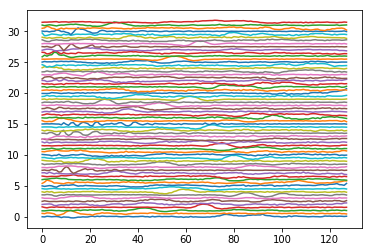

In [31]:
w = model.state_dict()['convnet.0.weight'][:,0,:,0].numpy()
n = 64
plt.plot(w[:n].T+np.arange(n)/2)

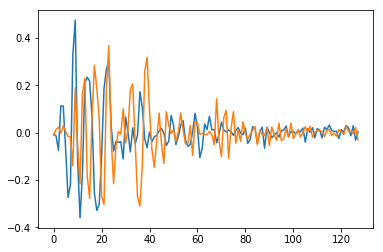

In [419]:
y, (speaker_id, phones) = data

spec = mel(y)
spec = tac.scaling.amplitude_to_db(spec)
# spec = modfilter(spec)

out = model(spec)
loss(out, phones[:,2:-2])

tensor(3.7042, grad_fn=<NllLoss2DBackward>)

In [318]:
phones.shape
t_spec.shape
spec.shape

lin = nn.Linear(256, 40)

lin(out).shape

torch.Size([297, 1, 40])

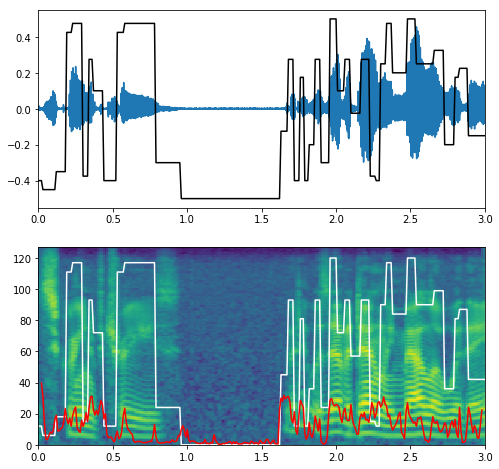

In [110]:
y, (speaker_id, phones) = test_dataset[0]
fs = test_dataset.sample_rate
ff = mel.mel_freq_vals

# audiofile = get_librispeech_filepath(librispeech_path, files[i_file][0])
# y, fs = torchaudio.load(audiofile)
# y = y[:,:3*fs-1]

tt = torch.arange(0, 3, 1/fs)
spec = mel(y[None,:,:])
spec = tac.scaling.amplitude_to_db(spec)
softmax = nn.Softmax(dim=1)
out = softmax(model(spec))
# spec = modfilter(spec)
t_spec = torch.arange(0, 3.001, .01)


fig, ax = plt.subplots(2,1)
ax[0].plot(tt.numpy(), y.numpy()[0])
ax[0].plot(t_spec.numpy(), np.array(phones)/40-.5, 'k')
ax[0].set_xlim([0,tt[-1]])
ax[1].pcolormesh(t_spec.numpy(), np.arange(ff.shape[0]), spec[0,0])
ax[1].plot(t_spec.numpy(), np.array(phones)*3, 'w')
ax[1].plot(t_spec[2:-2].numpy(),-torch.sum(out*torch.log(out),1).data.numpy()[0]*15,'r')
fig.set_size_inches([8,8])

In [266]:
import IPython
from IPython.display import Audio
IPython.display.display(Audio(y.numpy().squeeze(), rate=fs))

In [107]:
softmax = nn.Softmax(dim=1)
out = softmax(model(spec))

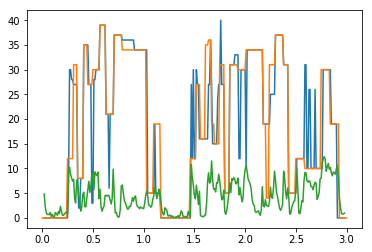

In [108]:
plt.plot(t_spec.numpy()[2:-2], out[0].argmax(0).numpy())
plt.plot(t_spec.numpy(), np.array(phones))
plt.plot(t_spec[2:-2].numpy(),-torch.sum(out*torch.log(out),1).data.numpy()[0]*5)

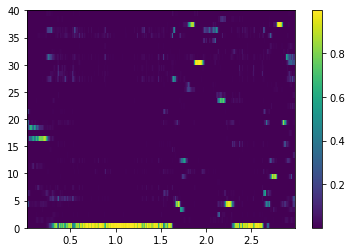

In [84]:
plt.pcolormesh(t_spec[2:-2], np.arange(41), out[0].data)
plt.colorbar()

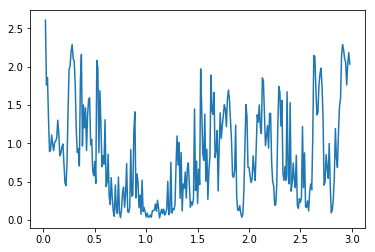

In [103]:
plt.plot(t_spec[2:-2].numpy(),-torch.sum(out*torch.log(out),1).data.numpy()[0])